## ASL Image Classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1ExYZMxcMRohKIhnZYo1l3ZNTZhENmUzO?usp=sharing"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

##Setup Kaggle and Import Dataset




In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kmarsyad","key":"0b2fab08fb1915b97629ea87647e49a5"}'}

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d mrgeislinger/asl-rgb-depth-fingerspelling-spelling-it-out

 99% 2.09G/2.11G [00:52<00:00, 49.3MB/s]
100% 2.11G/2.11G [00:52<00:00, 42.8MB/s]


In [6]:
! unzip /content/asl-rgb-depth-fingerspelling-spelling-it-out.zip -d /input

Streaming output truncated to the last 5000 lines.
  inflating: /input/dataset5/E/u/color_20_0231.png  
  inflating: /input/dataset5/E/u/color_20_0232.png  
  inflating: /input/dataset5/E/u/color_20_0233.png  
  inflating: /input/dataset5/E/u/color_20_0234.png  
  inflating: /input/dataset5/E/u/color_20_0235.png  
  inflating: /input/dataset5/E/u/color_20_0236.png  
  inflating: /input/dataset5/E/u/color_20_0237.png  
  inflating: /input/dataset5/E/u/color_20_0238.png  
  inflating: /input/dataset5/E/u/color_20_0239.png  
  inflating: /input/dataset5/E/u/color_20_0240.png  
  inflating: /input/dataset5/E/u/color_20_0241.png  
  inflating: /input/dataset5/E/u/color_20_0242.png  
  inflating: /input/dataset5/E/u/color_20_0243.png  
  inflating: /input/dataset5/E/u/color_20_0244.png  
  inflating: /input/dataset5/E/u/color_20_0245.png  
  inflating: /input/dataset5/E/u/color_20_0246.png  
  inflating: /input/dataset5/E/u/color_20_0247.png  
  inflating: /input/dataset5/E/u/color_20_0248.p

## Import Environments

In [104]:
from tensorflow import keras
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
import os, pathlib, cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [8]:
print(os.listdir("../input"))

['dataset5']


## Create Train and Test Split with ImageDataGenerator

In [102]:
data_dir = os.path.abspath('../input/dataset5/B')

In [68]:
IMAGE_SHAPE = (64, 64)
TRAINING_DATA_DIR = data_dir

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 5552 images belonging to 24 classes.
Found 22268 images belonging to 24 classes.


In [69]:
# Learn more about data batches

image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)

Image batch shape:  (32, 64, 64, 3)
Label batch shape:  (32, 24)


In [70]:
# Learn about dataset labels

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S'
 'T' 'U' 'V' 'W' 'X' 'Y']


## Model

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,  MaxPooling2D,  Activation, Dense, Flatten, Dropout


model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = (64,64,3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dense(24, activation = 'softmax'))

In [72]:
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 conv2d_16 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 conv2d_17 (Conv2D)          (None, 58, 58, 32)        9248      
                                                                 
 dropout_6 (Dropout)         (None, 58, 58, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 54, 54, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 64)      

In [58]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=0,factor=0.5, min_lr=0.00001)

In [74]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

from datetime import datetime 
batch_size=16
start1 = datetime.now() 
history = model.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch,
                    batch_size = 128,
                    epochs = 10, 
                    validation_data = valid_generator, 
                    validation_steps=val_steps_per_epoch,
                    callbacks = [learning_rate_reduction])

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

Epoch 1/10
696/696 [==============================] - 30s 43ms/step - loss: 0.0521 - accuracy: 0.9836 - val_loss: 1.8611 - val_accuracy: 0.7547 - lr: 0.0010
Epoch 2/10
696/696 [==============================] - 29s 42ms/step - loss: 0.0437 - accuracy: 0.9849 - val_loss: 1.8243 - val_accuracy: 0.7460 - lr: 0.0010
Epoch 3/10
696/696 [==============================] - 29s 42ms/step - loss: 0.0393 - accuracy: 0.9880 - val_loss: 1.3230 - val_accuracy: 0.7731 - lr: 0.0010
Epoch 4/10
696/696 [==============================] - 29s 42ms/step - loss: 0.0312 - accuracy: 0.9900 - val_loss: 1.3952 - val_accuracy: 0.7388 - lr: 0.0010
Epoch 5/10
696/696 [==============================] - 29s 42ms/step - loss: 0.0275 - accuracy: 0.9915 - val_loss: 1.7512 - val_accuracy: 0.7287 - lr: 0.0010
Epoch 6/10
696/696 [==============================] - 29s 42ms/step - loss: 0.0254 - accuracy: 0.9922 - val_loss: 1.6542 - val_accuracy: 0.7758 - lr: 0.0010
Epoch 7/10
696/696 [==============================] - 30s 

## Evaluate model on test set (GENERATOR VERSION)

In [75]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)

174/174 [==============================] - 6s 33ms/step - loss: 2.1340 - accuracy: 0.7444


In [76]:
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

Final loss: 2.13
Final accuracy: 74.44%


## Save and Load the model

In [78]:
ASL_SAVED_MODEL = "saved_models/asl1"
tf.saved_model.save(model, ASL_SAVED_MODEL)

INFO:tensorflow:Assets written to: saved_models/asl1/assets


INFO:tensorflow:Assets written to: saved_models/asl1/assets


In [81]:
# Load the SavedModel

asl_model = hub.load(ASL_SAVED_MODEL)
print(asl_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f643ccec990>


In [82]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 64, 64, 3)


In [83]:
tf_model_predictions = asl_model(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 24)


In [84]:
# Convert prediction results to Pandas dataframe, for better visualization

tf_pred_dataframe = pd.DataFrame(tf_model_predictions.numpy())
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,A,B,C,D,E,F,G,H,I,K,...,P,Q,R,S,T,U,V,W,X,Y
0,7.855231e-14,3.014565e-06,1.295861e-11,9.662620e-13,1.685330e-13,3.667665e-09,7.377125e-14,3.749599e-11,1.661875e-12,9.490908e-01,...,1.482544e-08,8.295853e-12,4.415734e-02,1.330529e-11,6.284799e-15,6.720773e-03,3.289876e-12,1.730368e-10,2.808815e-05,1.217236e-14
1,5.726816e-12,1.230697e-17,3.727451e-07,9.381111e-22,8.781915e-18,8.431390e-17,3.563341e-17,4.506849e-20,2.711653e-17,7.184844e-16,...,1.819661e-13,5.431968e-19,1.363217e-27,9.914470e-01,5.744926e-05,5.924303e-19,2.850815e-14,2.267294e-19,7.803696e-14,2.458233e-20
2,8.906488e-06,7.582711e-11,5.411836e-04,7.638820e-10,1.794772e-12,2.046270e-10,9.994463e-01,7.624442e-09,9.243434e-17,1.177707e-08,...,3.521693e-06,6.381887e-18,6.720110e-12,1.760506e-14,8.105910e-15,9.009667e-16,8.662972e-13,1.154227e-17,9.249197e-14,1.107686e-11
3,3.628342e-11,1.042273e-06,1.281193e-05,1.351647e-15,3.993807e-13,3.655694e-13,1.350757e-09,1.655791e-07,2.319696e-14,4.960605e-03,...,8.596340e-06,1.595686e-10,4.141588e-03,5.851224e-14,3.099073e-14,9.908687e-01,1.458529e-13,6.016733e-13,6.533623e-06,7.733063e-18
4,7.431574e-12,2.253827e-13,3.431089e-13,1.858262e-29,8.084850e-14,9.838617e-18,5.062041e-15,7.482391e-20,3.657718e-19,6.067121e-22,...,3.849846e-18,1.360077e-23,3.650899e-20,6.873849e-14,9.817979e-14,9.201029e-15,1.668075e-14,2.222458e-18,6.316361e-13,6.566832e-22


In [85]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

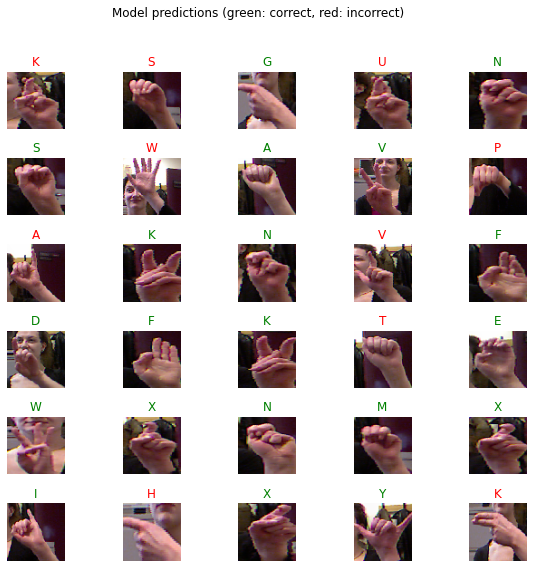

In [86]:
# Print images batch and labels predictions

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Convert Model to TFLite

In [89]:
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/asl.tflite"
TFLITE_QUANT_MODEL = "tflite_models/asl_quant.tflite"

In [90]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : asl_model(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)

print("TFLite models and their sizes:")
!ls "tflite_models" -lh

TFLite models and their sizes:
total 29M
-rw-r--r-- 1 root root 5.8M Jun 10 16:12 asl_quant.tflite
-rw-r--r-- 1 root root  24M Jun 10 16:12 asl.tflite


END!

## Test with Custom Images

In [29]:
uploaded = files.upload()

Saving asl-a-new-cropped.jpg to asl-a-new-cropped.jpg


In [91]:
def prepare_custom_images(filepath):
  img = cv2.imread(filepath)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  height = 64
  width = 64
  img = cv2.resize(img, (height, width))
  img = img / 255.
  print(img.shape)
    
  return img



In [92]:
custom_images_path = "/content/asl-a-new-cropped.jpg"
custom_images = prepare_custom_images(custom_images_path)

(64, 64, 3)


In [93]:
prediction = model.predict(prepare_custom_images(custom_images_path))

(64, 64, 3)


ValueError: ignored

In [94]:
from PIL import Image

In [95]:
image = np.array(Image.open("/content/asl-a-new-cropped.jpg").resize((64, 64)))
print("shape: ", image.shape)

shape:  (64, 64, 3)


In [96]:
model.predict(image).round()

ValueError: ignored

In [44]:
custom_images.shape

(64, 64, 3)

In [97]:
custom_preds = model.predict(prepare_custom_images(custom_images_path))
custom_preds



(64, 64, 3)


ValueError: ignored